In [707]:
import matplotlib.pyplot as plt
import os
import json
import dateutil
import logging
import statistics
import numpy as np
from datetime import *

In [708]:
def get_cca_folders(path,cca_type, start_date_inclusive, end_date_exclusive,start_hour,end_hour):
    all_folders = os.listdir(path)
    valid_folders=[]
    for folder_name in all_folders:
        try:
            date_obj=parse_folder_name(folder_name)
            if start_date_inclusive<=date_obj.date()<end_date_exclusive \
                    and start_hour<=date_obj.time()<=end_hour\
                    and cca_type in folder_name:
                valid_folders.append(folder_name)
        except:
            pass

    return valid_folders

In [709]:
def parse_folder_name(name):
    try:
        date_list = name.split('-')
        temp_date="2023-"+date_list[0]+"-"+date_list[1]+" "+date_list[2]
        return dateutil.parser.parse(temp_date)
    except:
        logging.warning(name+" cannot be parsed")

In [710]:
def sort_iperf_by_timestamp(iperf_jsons):
    outer_list_sorted = iperf_jsons
    outer_list_sorted=sorted(outer_list_sorted,key=lambda e: e[0]["start"]["timestamp"]["timesecs"])
    sorted_list =[]
    for outer in outer_list_sorted:
        sorted_list.append(sorted(outer,key=lambda e:e["start"]["timestamp"]["timesecs"]))
    return sorted_list


In [711]:
def get_jsons(path,cca_type,file_type,length,start_date_inclusive=date(2000,1,1), end_date_exclusive=date
    (3000,1,1),start_hour=time(0,0,0),end_hour=time(23,59,59)):
    folders=get_cca_folders(path,cca_type,start_date_inclusive,end_date_exclusive,start_hour,end_hour)
    result=[]
    for folder_name in folders:
        file_path = os.path.join(path,folder_name,length,file_type)
        temp_res = []
        for file in os.listdir(file_path):
            try:
                with open(os.path.join(file_path,file), 'r') as reading_file:
                    temp_res.append(json.load(reading_file))
            except:
                logging.warning(os.path.join(file_path,file)+" cannot be read as a valid json file or not existed, ignoring")
        if len(temp_res)>0:
            result.append(temp_res)
    if file_type=="iperf":
            result = sort_iperf_by_timestamp(result)
    return result

In [712]:
def average_sum_received(jsons):
    # in MegaBytes per second
    total=0
    length=0
    for file in jsons:
        try:
            total+=file["end"]["sum_received"]["bits_per_second"]/1024/1024
            length+=1
        except:
            logging.warning(json+" parsing fail when getting its sum received in remote")
    return total/length

In [713]:
def average_rtt(jsons):
    # in MegaBytes per second
    total=0
    length=0
    for file in jsons:
        try:

            total+=file["end"]["streams"][0]["sender"]["mean_rtt"]
            length+=1
        except:
            logging.warning(" parsing fail when getting its sum received in remote")
    return total/length

In [714]:
def average_retransmission(jsons):
    # in MegaBytes per second
    total=0
    length=0
    for file in jsons:
        try:
            total+=file["end"]["sum_sent"]["retransmits"]
            length+=1
        except:
            logging.warning(" parsing fail when getting its sum received in remote")
    return total/length

In [715]:
def draw_average_bits_per_second_received_against_time(jsons):
    ys = list(map(lambda e:average_sum_received(e),jsons))
    xs = list(map(lambda e:dateutil.parser.parse(e[0]["start"]["timestamp"]["time"]).astimezone(dateutil.tz.gettz('America/New_York')),jsons))
    print(statistics.stdev(ys))
    print(statistics.mean(ys))
    print("50th percentile of ys: ",np.percentile(ys, 1))
    plt.plot(xs,ys)
    plt.xticks(rotation=90)
    plt.show()

In [716]:
def draw_average_bits_per_second_cdf(jsons):
    ys = list(map(lambda e:average_sum_received(e),jsons))
    count, bins_count = np.histogram(ys, bins=1000)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.legend()
    plt.show()

In [717]:
def draw_rtt_against_time(jsons):
    ys = list(map(lambda e:average_rtt(e),jsons))
    xs = list(map(lambda e:dateutil.parser.parse(e[0]["start"]["timestamp"]["time"]).astimezone(dateutil.tz.gettz('America/New_York')),jsons))
    plt.plot(xs,ys)
    plt.xticks(rotation=90)
    plt.show()

In [718]:
def draw_average_rtt_cdf(jsons):
    ys = list(map(lambda e:average_rtt(e),jsons))
    count, bins_count = np.histogram(ys, bins=1000)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.legend()
    plt.show()

In [719]:
def draw_retransmission_against_time(jsons):
    ys = list(map(lambda e:average_retransmission(e),jsons))
    xs = list(map(lambda e:dateutil.parser.parse(e[0]["start"]["timestamp"]["time"]).astimezone(dateutil.tz.gettz('America/New_York')),jsons))
    plt.plot(xs,ys)
    plt.xticks(rotation=90)
    plt.show()

In [720]:
def draw_average_bits_per_second_by_hour(path,cca_type,length):
    average_bits_per_second =[]
    start_list=[]
    end_list =[]
    for i in range(0,24):
        for j in [0,30]:
            start_list.append(time(i,j,0))
        for j in [29,59]:
            end_list.append(time(i,j,0))

    ys =[]
    xs =[]
    for (start,end) in zip(start_list,end_list):
        xs.append(start.strftime('%H/%M'))
        files = get_jsons(path,cca_type,"iperf",length,start_hour=start,end_hour=end)
        bps_sum=0
        bps_count=0
        for file in files:
            bps_sum+=file[0]["end"]["sum_sent"]["bits_per_second"]
            bps_count+=1
        ys.append(bps_sum/bps_count/1024/1024)
    print(xs)
    plt.plot(xs,ys)
    plt.xticks(rotation=90)
    plt.show()



['00/00', '00/30', '01/00', '01/30', '02/00', '02/30', '03/00', '03/30', '04/00', '04/30', '05/00', '05/30', '06/00', '06/30', '07/00', '07/30', '08/00', '08/30', '09/00', '09/30', '10/00', '10/30', '11/00', '11/30', '12/00', '12/30', '13/00', '13/30', '14/00', '14/30', '15/00', '15/30', '16/00', '16/30', '17/00', '17/30', '18/00', '18/30', '19/00', '19/30', '20/00', '20/30', '21/00', '21/30', '22/00', '22/30', '23/00', '23/30']


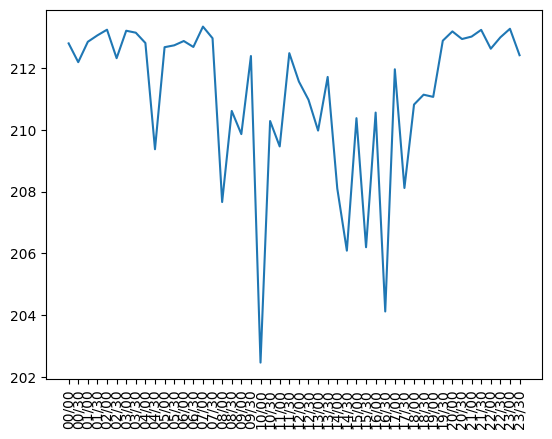

In [721]:
#logging.getLogger(__name__).setLevel(logging.ERROR)
a=get_jsons("/Users/nickdu/Downloads/output","bbr","iperf","180",start_date_inclusive=date(2023,4,4),start_hour=time(12,0,0),end_hour=time(12,30,0))
draw_average_bits_per_second_by_hour("/Users/nickdu/Downloads/output","bbr","180")
#draw_average_bits_per_second_received_against_time(get_jsons("/Users/nickdu/Downloads/output","cubic","iperf","180",start_date_inclusive=date(2023,4,4),start_hour=time(13,0,0),end_hour=time(14,59,59)))

